In [4]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## statistics
import statsmodels.formula.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

## internal
import midas

## Load Sample-Meta Data

- primary key = "unique_sample_id"

In [37]:
## Query sample meta-data from GM
train_meta = midas.m(f"select * from gold.modeling.obt_training_s3")
sample_id_discovery = midas.m(
                """select sample_id as unique_sample_id
                                                from gold.projects.project__by_sample
                                                where cgp_based_region_selection > 0"""
            )["unique_sample_id"]
train_meta = train_meta[train_meta["unique_sample_id"].isin(sample_id_discovery)]

## Focus on a subset of phenotypes
pdata_of_interest = ['unique_sample_id', 'batch_id', 'hyper_enrichment_panel', 'hypo_enrichment_panel', 
                     'methyl_input', 'max_maf_pct', 'age', 'sex', 'race', 'ethnicity', 'height_in', 'weight_lb', 'bmi',
                     'stage', 'sub_stage', 'g360_max_maf_pct', 'g360_max_maf_variant_name', 
                     'g360_driver_max_maf_pct', 'g360_driver_max_maf_variant_name', 
                     'sample_group','histological_subtype',  'cohort', 
                     'tvf_gene', 'tvf_variant_name', 'tvf_max_maf_pct']
train_meta_flt = train_meta.loc[:,pdata_of_interest]


## Drop columns with value = "NULL" across all samples
null_cols = [col for col in train_meta_flt.columns if (train_meta_flt[col].isnull()).all()]
train_meta_flt = train_meta_flt.drop(null_cols, axis=1)


## convert 'object' dtype to 'float' dtype, and filter out essential NaNs
train_meta_flt = train_meta_flt.assign(age = lambda df: np.where(df['age'] == 'None', np.nan, df['age']),
                                       g360_max_maf_pct = lambda df: np.where(df['g360_max_maf_pct'].isnull(), np.nan, df['g360_max_maf_pct'])).\
    dropna(subset = ['age', 'sample_group', 'cohort'])
train_meta_flt = train_meta_flt.astype({'age': 'float', 'g360_max_maf_pct': 'float'})
train_meta_flt = train_meta_flt.query(' sex != "UNKNOWN" ')

## info
train_meta_flt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3971 entries, 1364 to 46745
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   unique_sample_id                  3971 non-null   object 
 1   batch_id                          3971 non-null   object 
 2   hyper_enrichment_panel            3971 non-null   object 
 3   hypo_enrichment_panel             3971 non-null   object 
 4   methyl_input                      3914 non-null   object 
 5   age                               3971 non-null   float64
 6   sex                               3971 non-null   object 
 7   stage                             2976 non-null   object 
 8   sub_stage                         2976 non-null   object 
 9   g360_max_maf_pct                  2782 non-null   float64
 10  g360_max_maf_variant_name         2782 non-null   object 
 11  g360_driver_max_maf_pct           2434 non-null   object 
 12  g3

### Sample Meta-data Distribution across `sample_group` and `sex`

- `sns.boxplot()` filters `NaN` automatically

In [38]:
## 'sample_group' distribution
train_meta_flt.sample_group.value_counts()

breast         998
lung           996
cancer_free    995
crc            982
Name: sample_group, dtype: int64

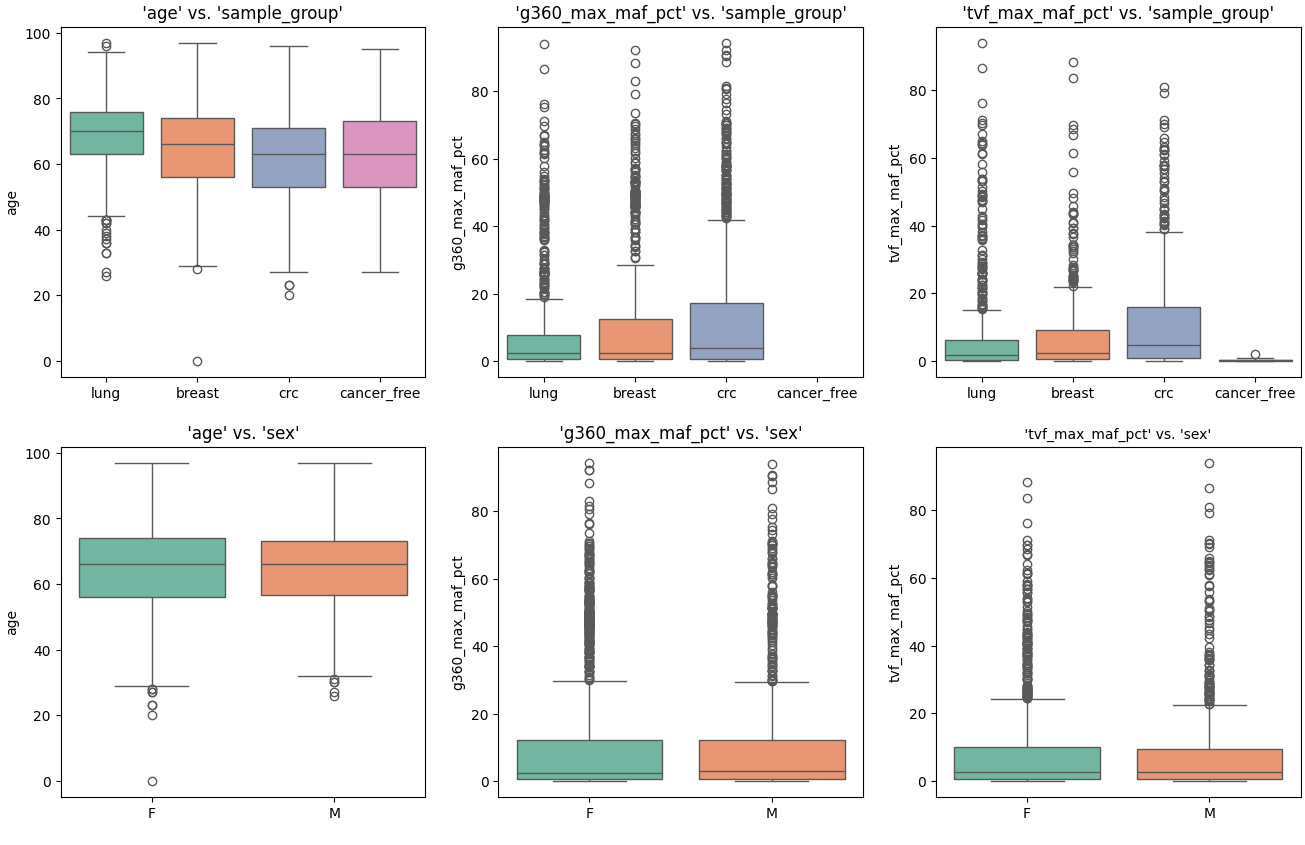

In [39]:
fig, axes = plt.subplots(2,3,figsize=(16,10))

with plt.style.context('_classic_test_patch'):

    ## age vs. sample_group
    sns.boxplot(data = train_meta_flt,
                x = 'sample_group',
                y = 'age',
                ax = axes[0,0],
                palette = 'Set2')

    axes[0,0].set_title(" 'age' vs. 'sample_group' ",fontsize=12)
    axes[0,0].set_xlabel(" ")

    ## g360_max_maf_pct vs. sample_group
    sns.boxplot(data = train_meta_flt,
                x = 'sample_group',
                y = 'g360_max_maf_pct',
                ax = axes[0,1],
                palette = 'Set2')

    axes[0,1].set_title(" 'g360_max_maf_pct' vs. 'sample_group' ",fontsize=12)
    axes[0,1].set_xlabel(" ")

    ## tvf_max_maf_pct vs. sample_group
    sns.boxplot(data = train_meta_flt,
                x = 'sample_group',
                y = 'tvf_max_maf_pct',
                ax = axes[0,2],
                palette = 'Set2')

    axes[0,2].set_title(" 'tvf_max_maf_pct' vs. 'sample_group' ",fontsize=12)
    axes[0,2].set_xlabel(" ")


    ## age vs. sex
    sns.boxplot(data = train_meta_flt,
                x = 'sex',
                y = 'age',
                ax = axes[1,0],
                palette = 'Set2')

    axes[1,0].set_title(" 'age' vs. 'sex' ",fontsize=12)
    axes[1,0].set_xlabel(" ")

   ## g360_max_maf_pct vs. sex
    sns.boxplot(data = train_meta_flt,
                x = 'sex',
                y = 'g360_max_maf_pct',
                ax = axes[1,1],
                palette = 'Set2')

    axes[1,1].set_title(" 'g360_max_maf_pct' vs. 'sex' ",fontsize=12)
    axes[1,1].set_xlabel(" ")

    ## tvf_max_maf_pct vs. sex
    sns.boxplot(data = train_meta_flt,
                x = 'sex',
                y = 'tvf_max_maf_pct',
                ax = axes[1,2],
                palette = 'Set2')

    axes[1,2].set_title(" 'tvf_max_maf_pct' vs. 'sex' ",fontsize=10)
    axes[1,2].set_xlabel(" ")

fig.savefig(os.getcwd() + "/../results/meta_info.png", dpi=400)

### `age` vs. `max_maf`

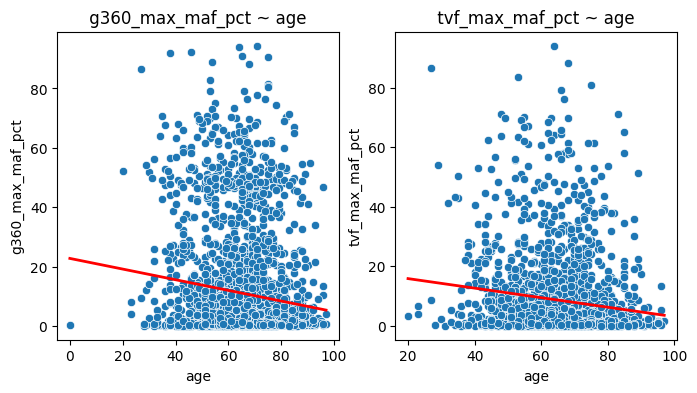

In [5]:
age_g360 = train_meta_flt.loc[:,['age','g360_max_maf_pct']].dropna()

age_g360['g360_max_maf_pct_pred'] = sm.ols(formula = "g360_max_maf_pct ~ age",
                                           data = age_g360).fit().fittedvalues

age_tvf = train_meta_flt.loc[:,['age','tvf_max_maf_pct']].dropna()
age_tvf['tvf_max_maf_pct_pred'] = sm.ols(formula = "tvf_max_maf_pct ~ age",
                                         data = age_tvf).fit().fittedvalues


fig, axes = plt.subplots(1,2,figsize=(8,4))

with plt.style.context('_classic_test_patch'):

    ## g360_max_maf_pct ~ age
    sns.scatterplot(x = "age",
                    y = "g360_max_maf_pct",
                    data = age_g360,
                    ax = axes[0])
    sns.lineplot(x = "age",
                 y = "g360_max_maf_pct_pred",
                 data = age_g360,
                 ax = axes[0],
                 color = 'red',
                 linewidth = 2)
    axes[0].set_title(" g360_max_maf_pct ~ age ",fontsize=12)
    
    ## tvf_max_maf_pct ~ age
    sns.scatterplot(x = "age",
                    y = "tvf_max_maf_pct",
                    data = age_tvf,
                    ax = axes[1])
    sns.lineplot(x = "age",
                 y = "tvf_max_maf_pct_pred",
                 data = age_tvf,
                 ax = axes[1],
                 color = 'red',
                 linewidth = 2)
    
    axes[1].set_title(" tvf_max_maf_pct ~ age ",fontsize=12)

## Load Region Score Data and Region-Meta Data

In [13]:
run = False

if run:
    ## Qurey region scores
    standard_flavor = "v1.2b_eldoradorius_b"
    region_score_tables = [
            f"/screening/data/methylation/sandbox_pipeline/flavors_spacebox_train/{standard_flavor}/intermediate_files/merged.msre_caller_mr_features.wideform.fth",
            f"/screening/data/methylation/sandbox_pipeline/flavors_spacebox_ldt/{standard_flavor}/intermediate_files/merged.msre_caller_mr_features.wideform.fth"
      ]
    region_score_ldt = pd.read_feather(region_score_tables[1]) ## "flavors_spacebox_ldt"  
    ## drop regions whose values are -5 across all samples
    no_molecule = [col for col in region_score_ldt.columns if (region_score_ldt[col]==-5).all()]
    region_score_ldt = region_score_ldt.drop(no_molecule, axis=1)
    region_ids = list(region_score_ldt.columns[region_score_ldt.columns != "unique_sample_id"])
    print(f"There are {len(region_ids)} regions.")
    
    ## Query region meta-data
    '''
    s3_region = "/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_regions.tsv"
    v6_region = "/screening/data/methylation/sandbox_pipeline/assets/mafband_v2023_12_23/msre_regions.tsv"
    s3_region_meta = pd.read_csv(s3_region, sep="\t")
    v6_region_meta = pd.read_csv(v6_region, sep="\t")
    '''
    
    ## Merge sample meta-data region score
    df_ldt = pd.merge(train_meta_flt,
                      region_score_ldt,
                      how = "left",
                      on = ["unique_sample_id"])

    print(f"The merged data frame has {df_ldt.shape[0]} samples and {df_ldt.shape[1]} features.")
    
    with open('../data/region_ids.pkl', 'wb') as f:
        pickle.dump(region_ids, f)
    
    with open('../data/df_ldt.pkl', 'wb') as f:
        pickle.dump(df_ldt, f)

else:
    with open('../data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

    with open('../data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

    print(type(region_ids))
    print(type(df_ldt))
    print(f"The merged data frame has {df_ldt.shape[0]} samples and {df_ldt.shape[1]} features.")

<class 'list'>
<class 'pandas.core.frame.DataFrame'>
The merged data frame has 3971 samples and 27361 features.


## Region Score Distribution across `sample_group` 

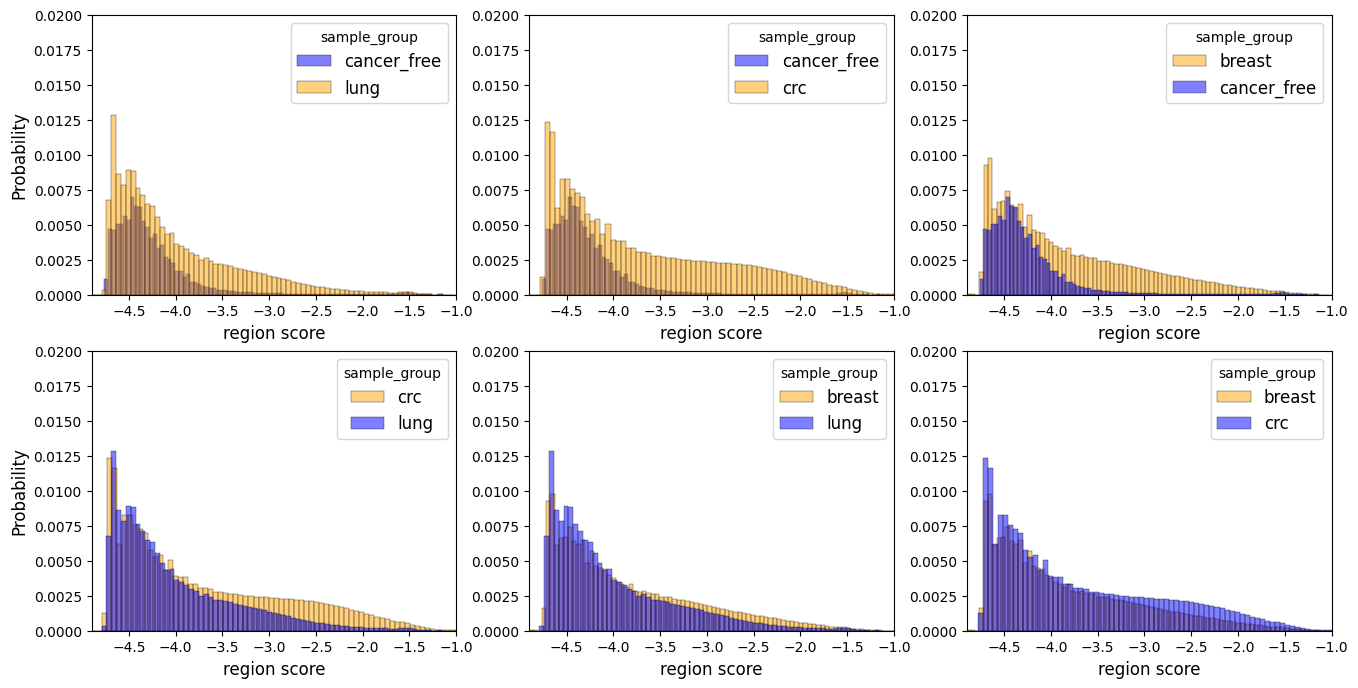

In [25]:
run = True
df = df_ldt.loc[:, ['unique_sample_id','sample_group']+region_ids].\
        set_index('unique_sample_id')
if run:
    
    
    fig, axes = plt.subplots(2,3,figsize=(16,8))
    
    with plt.style.context('_classic_test_patch'):
    
        ### lung vs. cancer_free
        for cancer_type, data in df.query(' sample_group == "lung" or sample_group == "cancer_free" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'cancer_free':'blue', 'lung': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[0,0])
    
        axes[0,0].legend(title = 'sample_group', fontsize=12)
        axes[0,0].set_xlabel('region score', fontsize=12)
        axes[0,0].set_ylabel('Probability', fontsize=12)
        axes[0,0].set_xlim(-4.9,-1)
        axes[0,0].set_ylim(0,0.02)
        
        
        ### crc vs. cancer_free
        for cancer_type, data in df.query(' sample_group == "crc" or sample_group == "cancer_free" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'cancer_free':'blue', 'crc': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[0,1])
    
        axes[0,1].legend(title = 'sample_group', fontsize=12)
        axes[0,1].set_xlabel('region score', fontsize=12)
        axes[0,1].set_ylabel('', fontsize=12)
        axes[0,1].set_xlim(-4.9,-1)
        axes[0,1].set_ylim(0,0.02)
    
        ### breast vs. cancer_free
        for cancer_type, data in df.query(' sample_group == "breast" or sample_group == "cancer_free" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'cancer_free':'blue', 'breast': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[0,2])
    
        axes[0,2].legend(title = 'sample_group', fontsize=12)
        axes[0,2].set_xlabel('region score', fontsize=12)
        axes[0,2].set_ylabel('', fontsize=12)
        axes[0,2].set_xlim(-4.9,-1)
        axes[0,2].set_ylim(0,0.02)

        ### lung vs. crc
        for cancer_type, data in df.query(' sample_group == "lung" or sample_group == "crc" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'lung':'blue', 'crc': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[1,0])
    
        axes[1,0].legend(title = 'sample_group', fontsize=12)
        axes[1,0].set_xlabel('region score', fontsize=12)
        axes[1,0].set_ylabel('Probability', fontsize=12)
        axes[1,0].set_xlim(-4.9,-1)
        axes[1,0].set_ylim(0,0.02)

        ### lung vs. breast
        for cancer_type, data in df.query(' sample_group == "lung" or sample_group == "breast" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'lung':'blue', 'breast': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[1,1])
    
        axes[1,1].legend(title = 'sample_group', fontsize=12)
        axes[1,1].set_xlabel('region score', fontsize=12)
        axes[1,1].set_ylabel('', fontsize=12)
        axes[1,1].set_xlim(-4.9,-1)
        axes[1,1].set_ylim(0,0.02)

        ### crc vs. breast
        for cancer_type, data in df.query(' sample_group == "crc" or sample_group == "breast" ').groupby("sample_group"):
            scores = data.drop(columns='sample_group').values.flatten()
            colors = {'crc':'blue', 'breast': 'orange'}
            sns.histplot(scores,
                         bins = 100,
                         label = cancer_type,
                         kde = False,
                         alpha = 0.5,
                         stat = 'probability',
                         color = colors[cancer_type],
                         ax = axes[1,2])
    
        axes[1,2].legend(title = 'sample_group', fontsize=12)
        axes[1,2].set_xlabel('region score', fontsize=12)
        axes[1,2].set_ylabel('', fontsize=12)
        axes[1,2].set_xlim(-4.9,-1)
        axes[1,2].set_ylim(0,0.02)

    # Save the figure
    fig.savefig(os.getcwd() + "/../results/region_score_by_sample_group.png", dpi=400)

else:
    fig, ax = plt.subplots(figsize=(16,10))
    img = Image.open(os.getcwd() + "/../results/region_score_by_sample_group.png")
    ax.imshow(img)

## mean(region_score) vs. std(region_score) across `sample_group`

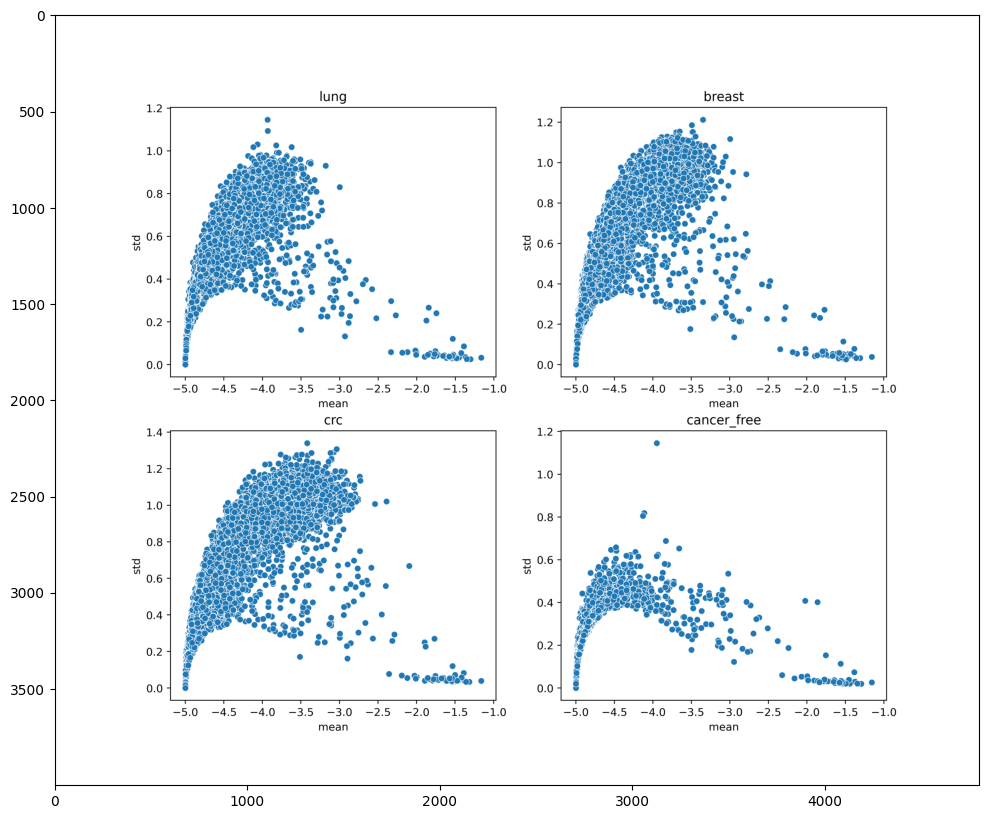

In [8]:
run = False

if run:
    tmp = df.groupby("sample_group").agg(['mean','std'])
    
    fig, axes = plt.subplots(2,2,figsize=(12,10))
    
    axes = axes.flatten()
    
    with plt.style.context('_classic_test_patch'):
        for idx, cancer_type in enumerate(df.sample_group.unique()):   
            
            sns.scatterplot(x = "mean",
                            y = "std",
                            data = tmp.loc[cancer_type,:].unstack(),
                            ax = axes[idx])
            axes[idx].set_title(cancer_type, fontsize=12)
    # Save the figure
    fig.savefig(os.getcwd() + "/../results/region_mean_vs_std_by_sample_group.png", dpi=400)

else:
    fig, ax = plt.subplots(figsize=(12,10))
    img = Image.open(os.getcwd() + "/../results/region_mean_vs_std_by_sample_group.png")
    ax.imshow(img)

## Pair-wise correlation

### Sample-level

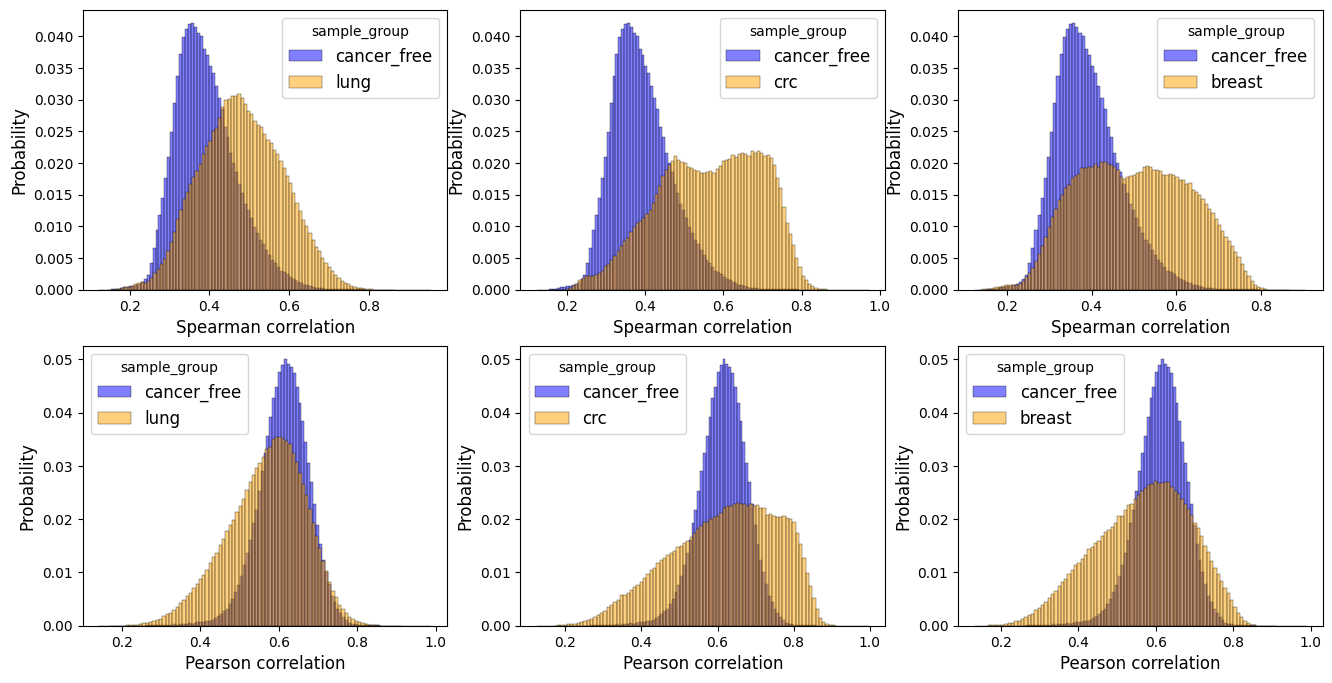

In [50]:
run = False

if run:
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_spearman.pkl', 'rb') as f:
        #sample_corr_sp_triu = pickle.load(f)
    
    ## Spearman
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_cancer_free_corr_sp.pkl', 'rb') as f:
        sample_cancer_free_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_lung_corr_sp.pkl', 'rb') as f:
        sample_lung_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_crc_corr_sp.pkl', 'rb') as f:
        sample_crc_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_breast_corr_sp.pkl', 'rb') as f:
        sample_breast_corr_sp = pickle.load(f)
    
    ## Pearson
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_cancer_free_corr_pe.pkl', 'rb') as f:
        sample_cancer_free_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_lung_corr_pe.pkl', 'rb') as f:
        sample_lung_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_crc_corr_pe.pkl', 'rb') as f:
        sample_crc_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_breast_corr_pe.pkl', 'rb') as f:
        sample_breast_corr_pr = pickle.load(f)
    
    
    fig, axes = plt.subplots(2,3,figsize=(16,8))
        
    with plt.style.context('_classic_test_patch'):
        
        ## cancer_free vs. lung
        sns.histplot(sample_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,0])
    
        sns.histplot(sample_lung_corr_sp,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,0])
        
        axes[0,0].legend(title = 'sample_group', fontsize=12)
        axes[0,0].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,0].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(sample_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,0])
    
        sns.histplot(sample_lung_corr_pr,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,0])
        
        axes[1,0].legend(title = 'sample_group', fontsize=12)
        axes[1,0].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,0].set_ylabel('Probability', fontsize=12)
    
        
    
        ## cancer_free vs. crc
        sns.histplot(sample_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,1])
    
        sns.histplot(sample_crc_corr_sp,
                     bins = 100,
                     label = "crc",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,1])
        
        axes[0,1].legend(title = 'sample_group', fontsize=12)
        axes[0,1].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,1].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(sample_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,1])
    
        sns.histplot(sample_crc_corr_pr,
                     bins = 100,
                     label = "crc",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,1])
        
        axes[1,1].legend(title = 'sample_group', fontsize=12)
        axes[1,1].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,1].set_ylabel('Probability', fontsize=12)
    
        ## cancer_free vs. breast
        sns.histplot(sample_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,2])
    
        sns.histplot(sample_breast_corr_sp,
                     bins = 100,
                     label = "breast",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,2])
        
        axes[0,2].legend(title = 'sample_group', fontsize=12)
        axes[0,2].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,2].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(sample_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,2])
    
        sns.histplot(sample_breast_corr_pr,
                     bins = 100,
                     label = "breast",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,2])
        
        axes[1,2].legend(title = 'sample_group', fontsize=12)
        axes[1,2].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,2].set_ylabel('Probability', fontsize=12)
    
        # Save the figure
        fig.savefig(os.getcwd() + "/../results/sample_corr.png", dpi=400)

else:
    fig, ax = plt.subplots(figsize=(16,10))
    img = Image.open(os.getcwd() + "/../results/sample_corr.png")
    ax.imshow(img)

### Region-level

In [9]:
run = False

if run:
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_spearman.pkl', 'rb') as f:
        #sample_corr_sp_triu = pickle.load(f)
    
    ## Spearman
    with open('/screening/notebooks/zhuang/summer_2024/data/region_cancer_free_corr_sp.pkl', 'rb') as f:
        region_cancer_free_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_lung_corr_sp.pkl', 'rb') as f:
        region_lung_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_crc_corr_sp.pkl', 'rb') as f:
        region_crc_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_breast_corr_sp.pkl', 'rb') as f:
        region_breast_corr_sp = pickle.load(f)
    
    ## Pearson
    with open('/screening/notebooks/zhuang/summer_2024/data/region_cancer_free_corr_pe.pkl', 'rb') as f:
        region_cancer_free_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_lung_corr_pe.pkl', 'rb') as f:
        region_lung_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_crc_corr_pe.pkl', 'rb') as f:
        region_crc_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_breast_corr_pe.pkl', 'rb') as f:
        region_breast_corr_pr = pickle.load(f)
    
    
    fig, axes = plt.subplots(2,3,figsize=(16,8))
        
    with plt.style.context('_classic_test_patch'):
        
        ## cancer_free vs. lung
        sns.histplot(region_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,0])
    
        sns.histplot(region_lung_corr_sp,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,0])
        
        axes[0,0].legend(title = 'sample_group', fontsize=12)
        axes[0,0].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,0].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(region_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,0])
    
        sns.histplot(region_lung_corr_pr,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,0])
        
        axes[1,0].legend(title = 'sample_group', fontsize=12)
        axes[1,0].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,0].set_ylabel('Probability', fontsize=12)
    
        
    
        ## cancer_free vs. crc
        sns.histplot(region_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,1])
    
        sns.histplot(region_crc_corr_sp,
                     bins = 100,
                     label = "crc",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,1])
        
        axes[0,1].legend(title = 'sample_group', fontsize=12)
        axes[0,1].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,1].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(region_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,1])
    
        sns.histplot(region_crc_corr_pr,
                     bins = 100,
                     label = "crc",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,1])
        
        axes[1,1].legend(title = 'sample_group', fontsize=12)
        axes[1,1].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,1].set_ylabel('Probability', fontsize=12)
    
        ## cancer_free vs. breast
        sns.histplot(region_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,2])
    
        sns.histplot(region_breast_corr_sp,
                     bins = 100,
                     label = "breast",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,2])
        
        axes[0,2].legend(title = 'sample_group', fontsize=12)
        axes[0,2].set_xlabel('Spearman correlation', fontsize=12)
        axes[0,2].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(region_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,2])
    
        sns.histplot(region_breast_corr_pr,
                     bins = 100,
                     label = "breast",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,2])
        
        axes[1,2].legend(title = 'sample_group', fontsize=12)
        axes[1,2].set_xlabel('Pearson correlation', fontsize=12)
        axes[1,2].set_ylabel('Probability', fontsize=12)
    
        # Save the figure
        fig.savefig(os.getcwd() + "/../results/region_corr.png", dpi=400)

else:
    fig, ax = plt.subplots(figsize=(16,10))
    img = Image.open(os.getcwd() + "/../results/region_corr.png")
    ax.imshow(img)


NameError: name 'plt' is not defined